In [ ]:
!pip3 install category_encoders

In [ ]:
import sys
import os
import category_encoders as ce
import numpy as np
import pandas as pd
import sklearn as skl
import sklearn.model_selection
import sklearn.metrics
from sklearn.impute import SimpleImputer


import matplotlib.pyplot as plt
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

import re

## Prep

In [ ]:
train_csv = '/content/train.csv'
test_csv = '/content/test.csv'

# new_test = 'data/test_modified_8.csv'
#aux_data = []
#aux_dir = '/content/sample_data/auxiliary_data'
#aux_csv = [f for f in os.listdir(aux_dir) if os.path.isfile(os.path.join(aux_dir,f))]

In [ ]:
df = pd.read_csv(train_csv)
df1 = pd.read_csv(test_csv)


In [ ]:
df.head(5)

,listing_id,name,street,type,model,market_segment,type_of_area,bedrooms,bathrooms,district,...,lat,lng,tenure,built_year,no_of_units,area_size,eco_category,accessibility,date_listed,price
0,6998418,seascape,57 cove way,condominium,condominium,ocr,strata,3,4.0,4,...,1.239337,103.837487,leasehold/99 years,2011.0,151.0,2336.0,uncategorized,guarded,2021-05-04,5390000.0
1,2046604,la maison,10 moulmein rise,apartment,apartment,ocr,strata,3,3.0,11,...,1.319533,103.847030,freehold,1999.0,24.0,1259.0,uncategorized,guarded,2021-05-07,2310000.0
2,7563513,viva,2 suffolk walk,condominium,condominium,ocr,strata,4,3.0,11,...,1.315656,103.844445,freehold,2012.0,235.0,1959.0,uncategorized,guarded,2021-06-30,5279500.0
3,3071445,urban treasures,205 jalan eunos,condominium,condominium,ocr,strata,3,2.0,14,...,1.329367,103.905791,freehold,NaN,237.0,883.0,uncategorized,guarded,2022-01-02,1843600.0
4,9667539,infini at east coast,east coast road,apartment,apartment,ocr,strata,3,3.0,15,...,1.309176,103.911352,freehold,NaN,36.0,1066.0,uncategorized,guarded,2021-12-24,2262700.0


Visulization and drawing insights to the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      26048 non-null  int64  
 1   name            26048 non-null  object 
 2   street          26048 non-null  object 
 3   type            26048 non-null  object 
 4   model           24768 non-null  object 
 5   market_segment  26048 non-null  object 
 6   type_of_area    26048 non-null  object 
 7   bedrooms        25644 non-null  object 
 8   bathrooms       24812 non-null  float64
 9   district        26048 non-null  int64  
 10  region          26048 non-null  object 
 11  planning_area   26048 non-null  object 
 12  subszone        26048 non-null  object 
 13  lat             26048 non-null  float64
 14  lng             26048 non-null  float64
 15  tenure          25761 non-null  object 
 16  built_year      16005 non-null  float64
 17  no_of_units     25006 non-null 

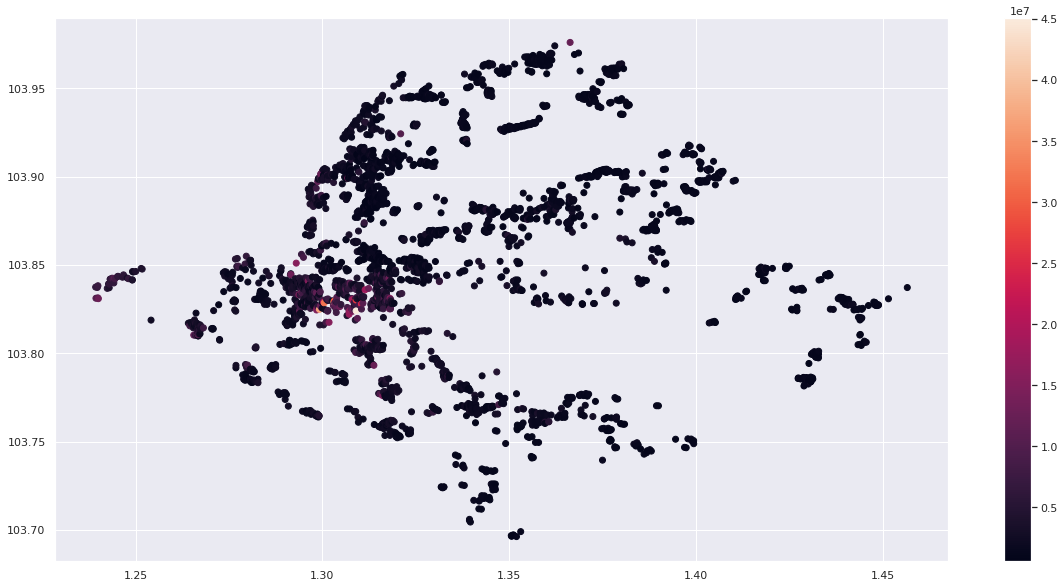

In [ ]:
import seaborn as sns
latlongprice = df.groupby(['lat', 'lng'])['price'].mean().reset_index()
sns.set(rc={'figure.figsize':(20,10)})
plt.scatter(latlongprice['lat'], latlongprice['lng'], c=latlongprice['price'])
plt.colorbar()
plt.show()
       

In [ ]:
#Grouping the dataset with respect to region,model  with respect to price
dataframe_region = df.groupby('region').price.agg(['max', 'min', 'count', 'median', 'mean'])
dataframe_model = df.groupby('model').price.agg(['max', 'min', 'count', 'median', 'mean'])


In [ ]:
dataframe_region

,max,min,count,median,mean
region,,,,,
central region,74800000.0,591800.0,17669,2288000.0,3.678558e+06
east region,19800000.0,613800.0,2558,1361800.0,1.508838e+06
north region,3649800.0,577500.0,855,1265000.0,1.371665e+06
north-east region,5280000.0,556600.0,2793,1419000.0,1.559955e+06
west region,8580000.0,605000.0,2173,1430000.0,1.665606e+06


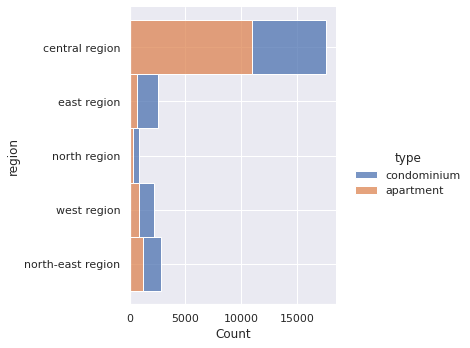

In [ ]:
# Adding histogram
sns.displot(df, y="region",hue='type',multiple="stack")

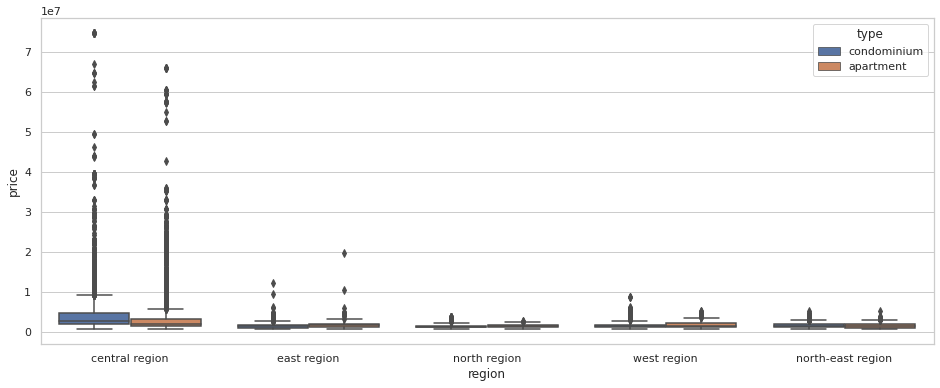

In [ ]:
#Adding Boxplot
plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="region", y="price",hue='type', data=df)

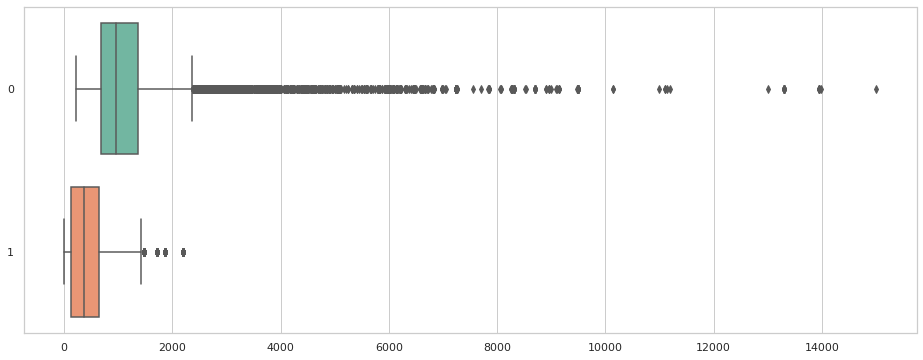

In [ ]:
data = [df['area_size'],df['no_of_units']]
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data= data, orient="h", palette="Set2").set()

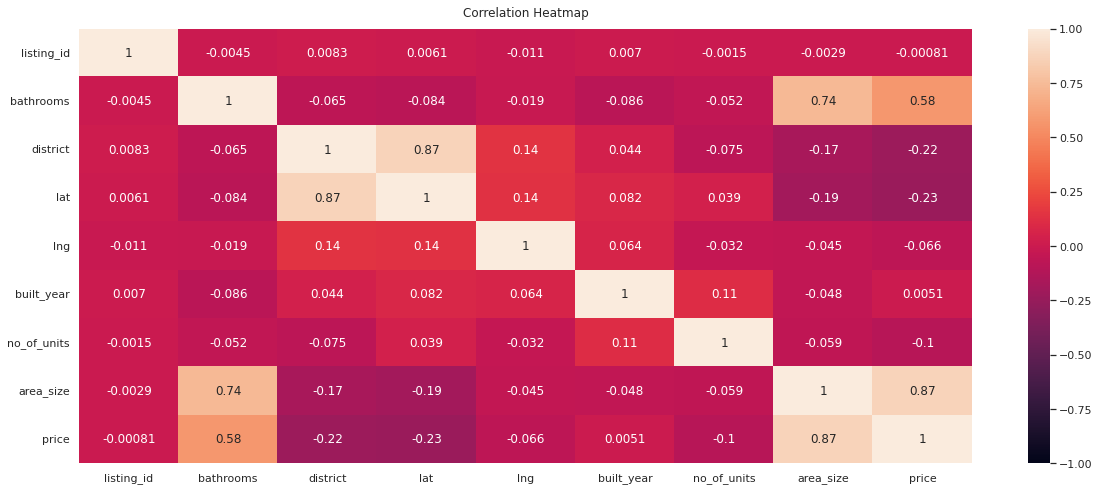

In [ ]:
# Generating heatmap
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
for col in df:
    print(col, len(df[col].unique()))

listing_id 26048
name 1650
street 3442
type 2
model 15
market_segment 1
type_of_area 1
bedrooms 18
bathrooms 10
district 27
region 5
planning_area 38
subszone 193
lat 3118
lng 3118
tenure 54
built_year 61
no_of_units 527
area_size 1179
eco_category 1
accessibility 1
date_listed 359
price 4704


## Data Cleaning

In [ ]:
# Fix Data types to display description correctly 

# bedroom to float (and add 'x+y' items to float)
def normalize_bedrooms(bed_row):
    pattern = re.compile(".[+].")
    if(bed_row != bed_row):
        return bed_row
    elif(pattern.match(bed_row)):
        return int(bed_row[0]) + int(bed_row[2])
    else:
        return bed_row
        
df['bedrooms'] = df['bedrooms'].map(normalize_bedrooms)
df['bedrooms'] = df['bedrooms'].astype(np.float64)

In [ ]:
str1="3+5"
num=list()
for i in str1.split('+'):
  num.append(i)
print(num)

['3', '5']


In [ ]:
# Drop Columns
# listing_id, built_year
# market_segment, type_of_area, eco_category, accessibility (have only one type each)

df = df.drop(columns = ['listing_id',  'market_segment', 'type_of_area', 'eco_category', 'accessibility'])


In [ ]:
df.isna().sum()

name                 0
street               0
type                 0
model             1280
bedrooms           404
bathrooms         1236
district             0
region               0
planning_area        0
subszone             0
lat                  0
lng                  0
tenure             287
built_year       10043
no_of_units       1042
area_size            2
date_listed          0
price                0
dtype: int64

In [ ]:
# Handling NaN Values

def impute_ordinal(df, ord_col):
    for col in ord_col:
        most_frequent = df[col].mode()[0]
        df[col] = df[col].fillna(most_frequent)
       
    return df

def impute_date(df, date_col):
    for col in date_col:
        most_frequent = df[col].mode()[0]
        df[col] = df[col].fillna(most_frequent)
    return df

def impute_num(df, num_col):   
    for col in num_col:
        mean = df[col].mean(skipna = True)
        df[col] = df[col].fillna(mean)
    return df

# df = df.dropna(axis = 0, how = 'any')


# Impute Ordinal as 'unknown'
ord_col = ['type', 'model', 'region', 'tenure']
df = impute_ordinal(df, ord_col)

# Impute Date NaNs with `most_frequent`
date_col = ['date_listed']
df = impute_date(df, date_col)

# Impute numeric NaNs with 'mean'
num_col = ['bedrooms', 'bathrooms', 'area_size', 'price']
df = impute_num(df, num_col)


In [ ]:
df1['built_year'].isna().sum()

2875

In [ ]:
df.isna().sum()

name                 0
street               0
type                 0
model                0
bedrooms             0
bathrooms            0
district             0
region               0
planning_area        0
subszone             0
lat                  0
lng                  0
tenure               0
built_year       10043
no_of_units       1042
area_size            0
date_listed          0
price                0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           26048 non-null  object 
 1   street         26048 non-null  object 
 2   type           26048 non-null  object 
 3   model          26048 non-null  object 
 4   bedrooms       26048 non-null  float64
 5   bathrooms      26048 non-null  float64
 6   district       26048 non-null  int64  
 7   region         26048 non-null  object 
 8   planning_area  26048 non-null  object 
 9   subszone       26048 non-null  object 
 10  lat            26048 non-null  float64
 11  lng            26048 non-null  float64
 12  tenure         26048 non-null  object 
 13  built_year     16005 non-null  float64
 14  no_of_units    25006 non-null  float64
 15  area_size      26048 non-null  float64
 16  date_listed    26048 non-null  object 
 17  price          26048 non-null  float64
dtypes: flo

In [ ]:
# Handle Dates
# date_listed -> separate into day_listed, month_listed, year_listed

def get_separated_dates(date, t='d'):
    p = re.compile("(\d+)-(\d+)-(\d+)")
    
    p_match = p.match(date)
    d = int(p_match.group(3))
    m = int(p_match.group(2))
    y = int(p_match.group(1))
    
    if t == 'd':
        return d
    if t == 'm':
        return m
    if t == 'y':
        return y
    
d = df['date_listed'].apply(lambda x: get_separated_dates(x, t='d'))
m = df['date_listed'].apply(lambda x: get_separated_dates(x, t='m'))
y = df['date_listed'].apply(lambda x: get_separated_dates(x, t='y'))

df['day_listed'] = d
df['month_listed'] =  m
df['year_listed'] = y



In [ ]:
# Handling Built year
names = list(df["name"].unique())
for name in names:
    # print(name)
    temp_df = df[df["name"] == name]
    try:
        temp_df["built_year"] = temp_df["built_year"].fillna(temp_df["built_year"].mode().iloc[0])
    except:
        temp_df["built_year"] = temp_df["built_year"].fillna(int(temp_df["date_listed"].min().split("-")[0]))

            
    try:
        temp_df["no_of_units"] = temp_df["no_of_units"].fillna(temp_df["no_of_units"].mode().iloc[0])
    except:
        temp_df["no_of_units"] = temp_df["no_of_units"].fillna(len(temp_df))
        


    for idx, row in temp_df.iterrows():
        df.loc[idx] = row

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [ ]:
df = df.drop('date_listed', axis=1)

In [ ]:
# Convert tenure to Ordinal
# tenure -> convert into categorical with categories: {freehold, <99, 99, 99<x<150, >=900}
def convert_tenure_to_cat(t_row):
    
    def categorize(year):
        if year < 99:
            return '_99'
        elif year == 99:
            return '99'
        elif year > 99 and year < 200:
            return '99_x_200'
        elif year >= 900:
            return '__900'
    
    pattern_years_from = re.compile("(\d+) (years) from")
    pattern_leasehold = re.compile("(leasehold/)(\d+) (years)")
    pattern_years = re.compile("^(\d+) (years)$")
    
    if(t_row != t_row):
        return t_row
    elif(pattern_years_from.match(t_row)):
        year = int(pattern_years_from.match(t_row).group(1))
        return categorize(year)
    elif(pattern_leasehold.match(t_row)):
        year = int(pattern_leasehold.match(t_row).group(2))
        return categorize(year)
    elif(pattern_years.match(t_row)):
        year = int(pattern_years.match(t_row).group(1))
        return categorize(year)
    else:
        return t_row
        
df['tenure'] = df['tenure'].map(convert_tenure_to_cat)

In [ ]:
df['tenure'].unique()

array(['99', 'freehold', '__900', '_99', '99_x_200'], dtype=object)

In [ ]:
# Prepare model classes
def normalize_model_class(df, model_class):
    model_class_test = df['model'].unique()
    i = 0
    
    for c in model_class_test:
        if c in model_class:
            i = i + 1
        else:
            df.loc[df.model == c, 'model'] = 'unknown'

    return df

model_class = ['condominium', 'apartment', 'executive condominium', 'penthouse', 'townhouse', 'walk-up apt', 'unknown']
df = normalize_model_class(df, model_class)
planning_area_class = df['planning_area'].unique()

In [ ]:
df['model'].unique()

array(['condominium', 'apartment', 'executive condominium', 'walk-up apt',
       'townhouse', 'unknown', 'penthouse'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           26048 non-null  object 
 1   street         26048 non-null  object 
 2   type           26048 non-null  object 
 3   model          26048 non-null  object 
 4   bedrooms       26048 non-null  float64
 5   bathrooms      26048 non-null  float64
 6   district       26048 non-null  int64  
 7   region         26048 non-null  object 
 8   planning_area  26048 non-null  object 
 9   subszone       26048 non-null  object 
 10  lat            26048 non-null  float64
 11  lng            26048 non-null  float64
 12  tenure         26048 non-null  object 
 13  built_year     26048 non-null  float64
 14  no_of_units    26048 non-null  float64
 15  area_size      26048 non-null  float64
 16  price          26048 non-null  float64
 17  day_listed     26048 non-null  int64  
 18  month_

In [ ]:
for col in df:
    print(col, len(df[col].unique()))

name 1650
street 3442
type 2
model 7
bedrooms 10
bathrooms 10
district 27
region 5
planning_area 38
subszone 193
lat 3118
lng 3118
tenure 5
built_year 61
no_of_units 529
area_size 1179
price 4704
day_listed 31
month_listed 12
year_listed 3


In [ ]:
df = df.drop(columns=['lat', 'lng'])

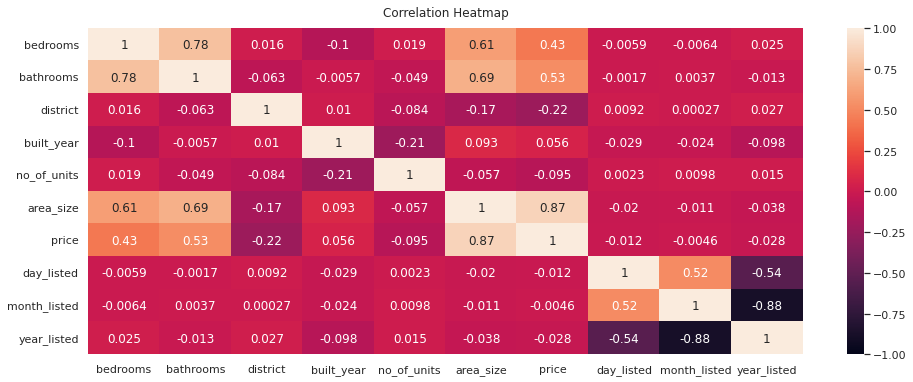

In [ ]:
# Generating heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
# One Hot encoding
df = pd.get_dummies(df, columns = ['type', 'model', 'region', 'tenure'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         26048 non-null  object 
 1   street                       26048 non-null  object 
 2   bedrooms                     26048 non-null  float64
 3   bathrooms                    26048 non-null  float64
 4   district                     26048 non-null  int64  
 5   planning_area                26048 non-null  object 
 6   subszone                     26048 non-null  object 
 7   built_year                   26048 non-null  float64
 8   no_of_units                  26048 non-null  float64
 9   area_size                    26048 non-null  float64
 10  price                        26048 non-null  float64
 11  day_listed                   26048 non-null  int64  
 12  month_listed                 26048 non-null  int64  
 13  year_listed     

In [ ]:
# Normalize Numerical Values

# min_df = {}
# max_df = {}
# for i,att in enumerate(df.describe(exclude=['O']).columns):
#     if(df[att].min() == 0 and (df[att].max() == 1 or df[att].max() == 0)):
#         continue
#     else:
#         min_df[att] = df[att].min()
#         max_df[att] = df[att].max()
#         df[att] = (df[att] - df[att].min())/(df[att].max() - df[att].min())


In [ ]:
print(len(df))
print(len(df.columns.unique()))
df.head()

26048
33


,name,street,bedrooms,bathrooms,district,planning_area,subszone,built_year,no_of_units,area_size,...,region_central region,region_east region,region_north region,region_north-east region,region_west region,tenure_99,tenure_99_x_200,tenure__99,tenure___900,tenure_freehold
0,seascape,57 cove way,3.0,4.0,4,southern islands,sentosa,2011.0,151.0,2336.0,...,1,0,0,0,0,1,0,0,0,0
1,la maison,10 moulmein rise,3.0,3.0,11,novena,moulmein,1999.0,24.0,1259.0,...,1,0,0,0,0,0,0,0,0,1
2,viva,2 suffolk walk,4.0,3.0,11,novena,moulmein,2012.0,235.0,1959.0,...,1,0,0,0,0,0,0,0,0,1
3,urban treasures,205 jalan eunos,3.0,2.0,14,bedok,kaki bukit,1930.0,237.0,883.0,...,0,1,0,0,0,0,0,0,0,1
4,infini at east coast,east coast road,3.0,3.0,15,bedok,frankel,2021.0,36.0,1066.0,...,0,1,0,0,0,0,0,0,0,1


## Training Model 

## Testing

In [ ]:
# Testing data Preprocessing
def preprocess_test(df, model_class):
    def normalize_bedrooms(bed_row):
        pattern_1 = re.compile("(\d+)[+](\d+)")
        pattern_2 = re.compile("(\d+)[+]")
        if(bed_row != bed_row):
            return bed_row
        elif(pattern_1.match(bed_row)):
            return pattern_1.match(bed_row).group(1) + pattern_1.match(bed_row).group(2) 
        elif(pattern_2.match(bed_row)):
            return pattern_2.match(bed_row).group(1)
        else:
            return bed_row
    
    def get_separated_dates(date, t='d'):
        p = re.compile("(\d+)-(\d+)-(\d+)")

        p_match = p.match(date)
        d = int(p_match.group(3))
        m = int(p_match.group(2))
        y = int(p_match.group(1))

        if t == 'd':
            return d
        if t == 'm':
            return m
        if t == 'y':
            return y
    
    def convert_tenure_to_cat(t_row):
    
        def categorize(year):
            if year < 99:
                return '_99'
            elif year == 99:
                return '99'
            elif year > 99 and year < 200:
                return '99_x_200'
            elif year >= 900:
                return '__900'

        pattern_years_from = re.compile("(\d+) (years) from")
        pattern_leasehold = re.compile("(leasehold/)(\d+) (years)")
        pattern_years = re.compile("^(\d+) (years)$")

        if(t_row != t_row):
            return t_row
        elif(pattern_years_from.match(t_row)):
            year = int(pattern_years_from.match(t_row).group(1))
            return categorize(year)
        elif(pattern_leasehold.match(t_row)):
            year = int(pattern_leasehold.match(t_row).group(2))
            return categorize(year)
        elif(pattern_years.match(t_row)):
            year = int(pattern_years.match(t_row).group(1))
            return categorize(year)
        else:
            return t_row
    
    def normalize_model_class(df, model_class):
        model_class_test = df['model'].unique()
        i = 0

        for c in model_class_test:
            if c in model_class:
                i = i + 1
            else:
                df.loc[df.model == c, 'model'] = 'unknown'

        return df
    
    def impute_ordinal(df, ord_col):
        for col in ord_col:
            most_frequent = df[col].mode()[0]
            df[col] = df[col].fillna(most_frequent)
            # df[col] = df[col].fillna(value='unknown', axis=0)
        return df

    def impute_date(df, date_col):
        for col in date_col:
            most_frequent = df[col].mode()[0]
            df[col] = df[col].fillna(most_frequent)
        return df

    def impute_num(df, num_col):   
        for col in num_col:
            mean = df[col].mean(skipna = True)
            df[col] = df[col].fillna(mean)
        return df
    
    df['district'] = df['district'].astype('O')
    df['listing_id'] = df['listing_id'].astype('O')

    # bedroom to float (and add 'x+y' items to float)
    df['bedrooms'] = df['bedrooms'].map(normalize_bedrooms)
    df['bedrooms'] = df['bedrooms'].astype(np.float64)
    
    # Drop Columns
    df = df.drop(columns = [ 'listing_id', 'market_segment', 'type_of_area', 'eco_category', 'accessibility', 'lat', 'lng'])
    
    # Impute N/A Values
    ord_col = ['type', 'model', 'region', 'tenure']
    df = impute_ordinal(df, ord_col)
    date_col = ['date_listed']
    df = impute_date(df, date_col)
    num_col = ['bedrooms', 'bathrooms', 'no_of_units', 'area_size']
    df = impute_num(df, num_col)
    
    # Separate Dates    
    d = df['date_listed'].apply(lambda x: get_separated_dates(x, t='d'))
    m = df['date_listed'].apply(lambda x: get_separated_dates(x, t='m'))
    y = df['date_listed'].apply(lambda x: get_separated_dates(x, t='y'))

    df['day_listed'] = d
    df['month_listed'] =  m
    df['year_listed'] = y

   # df = df.drop('date_listed', axis=1)
    
    # Convert tenure    
    df['tenure'] = df['tenure'].map(convert_tenure_to_cat)
    
    # Normalize model and planning_area unknown values
    model_class = model_class
    df = normalize_model_class(df, model_class)
    
    # One Hot Encoding
    df = pd.get_dummies(df, columns = ['type', 'model', 'region', 'tenure'])

    # Handling built_year


    # # Normalize Numerical Values
    # for att in df.describe(exclude=['O']).columns:
    #     if(df[att].min() == 0 and (df[att].max() == 1 or df[att].max() == 0)):
    #         continue
    #     else:
    #         df[att] = (df[att] - min_df[att])/(max_df[att] - min_df[att])
    
    return df
    

df_test = preprocess_test(df1, model_class)

In [ ]:
#Handling built year for test data
names = list(df_test["name"].unique())
for name in names:
    # print(name)
    temp_df = df_test[df_test["name"] == name]
    try:
        temp_df["built_year"] = temp_df["built_year"].fillna(temp_df["built_year"].mode().iloc[0])
    except:
        temp_df["built_year"] = temp_df["built_year"].fillna(int(temp_df["date_listed"].min().split("-")[0]))
            
    try:
        temp_df["no_of_units"] = temp_df["no_of_units"].fillna(temp_df["no_of_units"].mode().iloc[0])
    except:
        temp_df["no_of_units"] = temp_df["no_of_units"].fillna(len(temp_df))
    for idx, row in temp_df.iterrows():
        df_test.loc[idx] = row

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
df.isna().sum()

name                           0
street                         0
bedrooms                       0
bathrooms                      0
district                       0
planning_area                  0
subszone                       0
built_year                     0
no_of_units                    0
area_size                      0
price                          0
day_listed                     0
month_listed                   0
year_listed                    0
type_apartment                 0
type_condominium               0
model_apartment                0
model_condominium              0
model_executive condominium    0
model_penthouse                0
model_townhouse                0
model_unknown                  0
model_walk-up apt              0
region_central region          0
region_east region             0
region_north region            0
region_north-east region       0
region_west region             0
tenure_99                      0
tenure_99_x_200                0
tenure__99

In [ ]:
df_test = df_test.drop('date_listed', axis=1)

In [ ]:
# Target encoding
def target_encoding(train_df, test_df, features):
  targ_enc = ce.TargetEncoder(cols=features)
  targ_enc.fit(train_df[features], train_df['price'])

  train_df = train_df.join(targ_enc.transform(train_df[features]).add_suffix('_target'))
  test_df = test_df.join(targ_enc.transform(test_df[features]).add_suffix('_target'))

  train_df = train_df.drop(features, axis=1)
  test_df = test_df.drop(features, axis=1)

  return train_df, test_df

features_list = ['name', 'street', 'subszone','planning_area']
df, df_test = target_encoding(df, df_test, features_list)


In [ ]:
df_temp = df_flag = df_test

In [ ]:
df_temp.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bedrooms                     7500 non-null   float64
 1   bathrooms                    7500 non-null   float64
 2   district                     7500 non-null   object 
 3   built_year                   7500 non-null   float64
 4   no_of_units                  7500 non-null   float64
 5   area_size                    7500 non-null   float64
 6   day_listed                   7500 non-null   int64  
 7   month_listed                 7500 non-null   int64  
 8   year_listed                  7500 non-null   int64  
 9   type_apartment               7500 non-null   uint8  
 10  type_condominium             7500 non-null   uint8  
 11  model_apartment              7500 non-null   uint8  
 12  model_condominium            7500 non-null   uint8  
 13  model_executive co

In [ ]:
len(df_test['built_year'].unique())

60

In [ ]:
df.head(10)

,bedrooms,bathrooms,district,built_year,no_of_units,area_size,price,day_listed,month_listed,year_listed,...,region_west region,tenure_99,tenure_99_x_200,tenure__99,tenure___900,tenure_freehold,name_target,street_target,subszone_target,planning_area_target
0,3.0,4.0,4,2011.0,151.0,2336.0,5390000.0,4,5,2021,...,0,1,0,0,0,0,6.705755e+06,6.449625e+06,5.831660e+06,5.831660e+06
1,3.0,3.0,11,1999.0,24.0,1259.0,2310000.0,7,5,2021,...,0,0,0,0,0,1,4.419671e+06,2.994669e+06,2.771657e+06,2.475240e+06
2,4.0,3.0,11,2012.0,235.0,1959.0,5279500.0,30,6,2021,...,0,0,0,0,0,1,8.739571e+06,5.630194e+06,2.771657e+06,2.475240e+06
3,3.0,2.0,14,1930.0,237.0,883.0,1843600.0,2,1,2022,...,0,0,0,0,0,1,1.772242e+06,1.742946e+06,1.368666e+06,1.584515e+06
4,3.0,3.0,15,2021.0,36.0,1066.0,2262700.0,24,12,2021,...,0,0,0,0,0,1,2.033815e+06,1.969486e+06,1.839614e+06,1.584515e+06
5,2.0,1.0,27,1930.0,448.0,678.0,1131900.0,4,1,2022,...,0,1,0,0,0,0,1.494765e+06,1.449426e+06,1.519408e+06,1.474157e+06
6,4.0,3.0,23,1930.0,564.0,1249.0,2189000.0,5,1,2022,...,1,1,0,0,0,0,1.468034e+06,1.294878e+06,1.414124e+06,1.329559e+06
7,3.0,2.0,19,2021.0,680.0,936.0,1595000.0,17,12,2021,...,0,1,0,0,0,0,1.796229e+06,1.731254e+06,1.744408e+06,1.437086e+06
8,1.0,1.0,7,2021.0,219.0,409.0,1490500.0,25,12,2021,...,0,1,0,0,0,0,2.434969e+06,2.326183e+06,8.970847e+06,4.383065e+06
9,1.0,1.0,2,2014.0,202.0,592.0,1265000.0,24,9,2021,...,0,1,0,0,0,0,1.535560e+06,1.519871e+06,2.455189e+06,4.383065e+06


In [ ]:
df.to_csv(path_or_buf='/content/sample_data/train_data.csv', index=False)
df_temp.to_csv(path_or_buf='/content/sample_data/test_data.csv', index=False)